## 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터셋 압축 해제

In [ ]:
!unzip /content/drive/MyDrive/hole_dataset.ZIP -d /content/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/synthetic_data/train/segmentations/file_000006356.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006357.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006358.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006359.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006360.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006361.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006362.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006363.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006364.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006365.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006366.png  
  inflating: /content/synthetic_data/train/segmentations/file_000006367.png  
  inflating: /content/synthe

---
# EDA

## 라이브러리 import & 데이터 로드

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 데이터 로드
with open('/content/real_labeled_test_set/coco_segmentations.json', 'r') as f:
    data = json.load(f)

# 2. DataFrame으로 변환
images_df = pd.DataFrame(data['images'])
annotations_df = pd.DataFrame(data['annotations'])
categories_df = pd.DataFrame(data['categories'])

print("=== 기본 정보 ===")
print(f"Images: {len(images_df)}")
print(f"Annotations: {len(annotations_df)}")
print(f"Categories: {len(categories_df)}")

=== 기본 정보 ===
Images: 1680
Annotations: 6697
Categories: 7


### 데이터셋 기본 통계 정보 & 이미지 분포 분석

In [ ]:
# 클래스별 데이터 개수
category_counts = annotations_df['category_id'].value_counts().sort_index()
print("\n=== 클래스별 데이터 개수 ===")
for cat_id, count in category_counts.items():
    cat_name = categories_df[categories_df['id'] == cat_id]['name'].iloc[0]
    print(f"{cat_name} (ID: {cat_id}): {count}개")

# 카메라별 이미지 개수
cam_distribution = images_df['cam_name'].value_counts()
print("\n=== 카메라별 이미지 개수 ===")
print(cam_distribution)

# trigger_mm별 이미지 개수
trigger_distribution = images_df['trigger_mm'].value_counts().sort_index()
print("\n=== 촬영 거리별 이미지 개수 ===")
print(trigger_distribution)

# inspection_id별 이미지 개수 (부품당 몇 장씩 촬영되었는지)
images_per_inspection = images_df['inspection_id'].value_counts()
print("\n=== 부품당 촬영 이미지 개수 통계 ===")
print(f"평균: {images_per_inspection.mean():.2f}장")
print(f"최소: {images_per_inspection.min()}장")
print(f"최대: {images_per_inspection.max()}장")
print(f"표준편차: {images_per_inspection.std():.2f}")


=== 클래스별 데이터 개수 ===
AX1 (ID: 0): 354개
BY1 (ID: 1): 1467개
CY1 (ID: 2): 630개
DY1 (ID: 3): 1073개
DY2 (ID: 4): 1280개
DY3 (ID: 5): 846개
DY4 (ID: 6): 1047개

=== 카메라별 이미지 개수 ===
cam_name
Z1CAM08    320
Z1CAM07    320
Z1CAM05    320
Z1CAM02    240
Z1CAM06    240
Z1CAM04    160
Z1CAM03     80
Name: count, dtype: int64

=== 촬영 거리별 이미지 개수 ===
trigger_mm
700     240
800      80
1100    160
1200    480
1300    240
1500     80
1700    320
1800     80
Name: count, dtype: int64

=== 부품당 촬영 이미지 개수 통계 ===
평균: 19.53장
최소: 3장
최대: 21장
표준편차: 4.10


### 바운딩 박스 분석

In [ ]:
# bbox 정보 추출
annotations_df['bbox_x'] = annotations_df['bbox'].apply(lambda x: x[0])
annotations_df['bbox_y'] = annotations_df['bbox'].apply(lambda x: x[1])
annotations_df['bbox_width'] = annotations_df['bbox'].apply(lambda x: x[2])
annotations_df['bbox_height'] = annotations_df['bbox'].apply(lambda x: x[3])

print("\n=== 바운딩 박스 크기 통계 ===")
print("Width 통계:")
print(annotations_df['bbox_width'].describe())
print("\nHeight 통계:")
print(annotations_df['bbox_height'].describe())
print("\nArea 통계:")
print(annotations_df['area'].describe())

# 클래스별 평균 홀 크기
print("\n=== 클래스별 홀 크기 통계 ===")
for cat_id in sorted(annotations_df['category_id'].unique()):
    cat_name = categories_df[categories_df['id'] == cat_id]['name'].iloc[0]
    cat_data = annotations_df[annotations_df['category_id'] == cat_id]
    print(f"\n{cat_name} (ID: {cat_id}):")
    print(f"  평균 Width: {cat_data['bbox_width'].mean():.2f}")
    print(f"  평균 Height: {cat_data['bbox_height'].mean():.2f}")
    print(f"  평균 Area: {cat_data['area'].mean():.2f}")


=== 바운딩 박스 크기 통계 ===
Width 통계:
count    6697.000000
mean      155.391686
std       241.746670
min         2.339327
25%        21.977016
50%        39.115204
75%        91.962341
max      1070.226440
Name: bbox_width, dtype: float64

Height 통계:
count    6697.000000
mean      153.258765
std       288.811427
min         4.196721
25%        24.957703
50%        37.586563
75%        71.619048
max      1062.536133
Name: bbox_height, dtype: float64

Area 통계:
count    6.697000e+03
mean     7.151520e+04
std      1.961026e+05
min      1.145693e+01
25%      6.072661e+02
50%      1.455527e+03
75%      3.388152e+04
max      1.050891e+06
Name: area, dtype: float64

=== 클래스별 홀 크기 통계 ===

AX1 (ID: 0):
  평균 Width: 239.64
  평균 Height: 192.57
  평균 Area: 42698.78

BY1 (ID: 1):
  평균 Width: 554.61
  평균 Height: 551.96
  평균 Area: 312754.49

CY1 (ID: 2):
  평균 Width: 20.00
  평균 Height: 22.26
  평균 Area: 485.12

DY1 (ID: 3):
  평균 Width: 40.56
  평균 Height: 39.85
  평균 Area: 1715.00

DY2 (ID: 4):
  평균 Width: 31.39


### 클래스 별 상세 분석
- 클래스 별 평균 홀 크기 통계 출력

In [ ]:
import pandas as pd

# 바운딩 박스 크기 통계 요약을 DataFrame으로 생성
bbox_stats = pd.DataFrame({
    'bbox_width': annotations_df['bbox_width'].describe(),
    'bbox_height': annotations_df['bbox_height'].describe(),
    'area': annotations_df['area'].describe()
})
print("\n=== 바운딩 박스 크기 통계 ===")
print(bbox_stats)

# 클래스별 평균 홀 크기 통계 DataFrame 생성
class_stats_list = []

for cat_id in sorted(annotations_df['category_id'].unique()):
    cat_name = categories_df[categories_df['id'] == cat_id]['name'].iloc[0]
    cat_data = annotations_df[annotations_df['category_id'] == cat_id]
    class_stats_list.append({
        'category_id': cat_id,
        'category_name': cat_name,
        'mean_bbox_width': cat_data['bbox_width'].mean(),
        'mean_bbox_height': cat_data['bbox_height'].mean(),
        'mean_area': cat_data['area'].mean()
    })

class_stats_df = pd.DataFrame(class_stats_list)

print("\n=== 클래스별 홀 크기 통계 ===")
print(class_stats_df)


=== 바운딩 박스 크기 통계 ===
        bbox_width  bbox_height          area
count  6697.000000  6697.000000  6.697000e+03
mean    155.391686   153.258765  7.151520e+04
std     241.746670   288.811427  1.961026e+05
min       2.339327     4.196721  1.145693e+01
25%      21.977016    24.957703  6.072661e+02
50%      39.115204    37.586563  1.455527e+03
75%      91.962341    71.619048  3.388152e+04
max    1070.226440  1062.536133  1.050891e+06

=== 클래스별 홀 크기 통계 ===
   category_id category_name  mean_bbox_width  mean_bbox_height      mean_area
0            0           AX1       239.639180        192.566095   42698.783656
1            1           BY1       554.608825        551.961813  312754.493851
2            2           CY1        20.000598         22.261291     485.117819
3            3           DY1        40.560396         39.850268    1714.996624
4            4           DY2        31.392646         32.852942    1118.192492
5            5           DY3        14.350716         16.266575     

### 데이터 품질 분석
- 라벨링 완료율(is_graded 비율)
- segmentation 정보 등

In [ ]:
# is_graded 비율 (라벨링 완료율)
grading_status = annotations_df['is_graded'].value_counts()
print("\n=== 라벨링 품질 상태 ===")
print(grading_status)
print(f"완료율: {grading_status.get(True, 0) / len(annotations_df) * 100:.2f}%")

# segmentation이 비어있는 비율
empty_segmentation_count = sum(1 for _, row in annotations_df.iterrows() if not row['segmentation'])
print(f"\n=== Segmentation 정보 ===")
print(f"빈 segmentation: {empty_segmentation_count}개 ({empty_segmentation_count/len(annotations_df)*100:.2f}%)")

# ignore, iscrowd 상태
print("\n=== 기타 플래그 ===")
print(f"ignore=1인 데이터: {(annotations_df['ignore'] == 1).sum()}개")
print(f"iscrowd=1인 데이터: {(annotations_df['iscrowd'] == 1).sum()}개")


=== 라벨링 품질 상태 ===
is_graded
True     4097
False    2600
Name: count, dtype: int64
완료율: 61.18%

=== Segmentation 정보 ===
빈 segmentation: 6697개 (100.00%)

=== 기타 플래그 ===
ignore=1인 데이터: 0개
iscrowd=1인 데이터: 0개


### 이미지당 어노테이션 분석

In [ ]:
# 이미지당 홀 개수 분포
annotations_per_image = annotations_df['image_id'].value_counts()
print("\n=== 이미지당 어노테이션 개수 ===")
print(f"평균: {annotations_per_image.mean():.2f}개")
print(f"최소: {annotations_per_image.min()}개")
print(f"최대: {annotations_per_image.max()}개")
print("\n개수별 분포:")
print(annotations_per_image.value_counts().sort_index())

# 어노테이션이 없는 이미지 확인
all_image_ids = set(images_df['id'])
annotated_image_ids = set(annotations_df['image_id'])
missing_annotations = all_image_ids - annotated_image_ids
print(f"\n어노테이션이 없는 이미지: {len(missing_annotations)}개")


=== 이미지당 어노테이션 개수 ===
평균: 4.51개
최소: 1개
최대: 7개

개수별 분포:
count
1     16
2    184
3     79
4    217
5    790
6    135
7     64
Name: count, dtype: int64

어노테이션이 없는 이미지: 195개


## 🔷 폰트 설치

In [ ]:
!apt-get update -qq
!apt-get install -y fonts-nanum

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (20.5 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

# 설치된 나눔고딕 폰트 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 등록
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 음수 부호가 깨지는 문제 방지
matplotlib.rcParams['axes.unicode_minus'] = False

## 시각화
### 전체 분포 개요

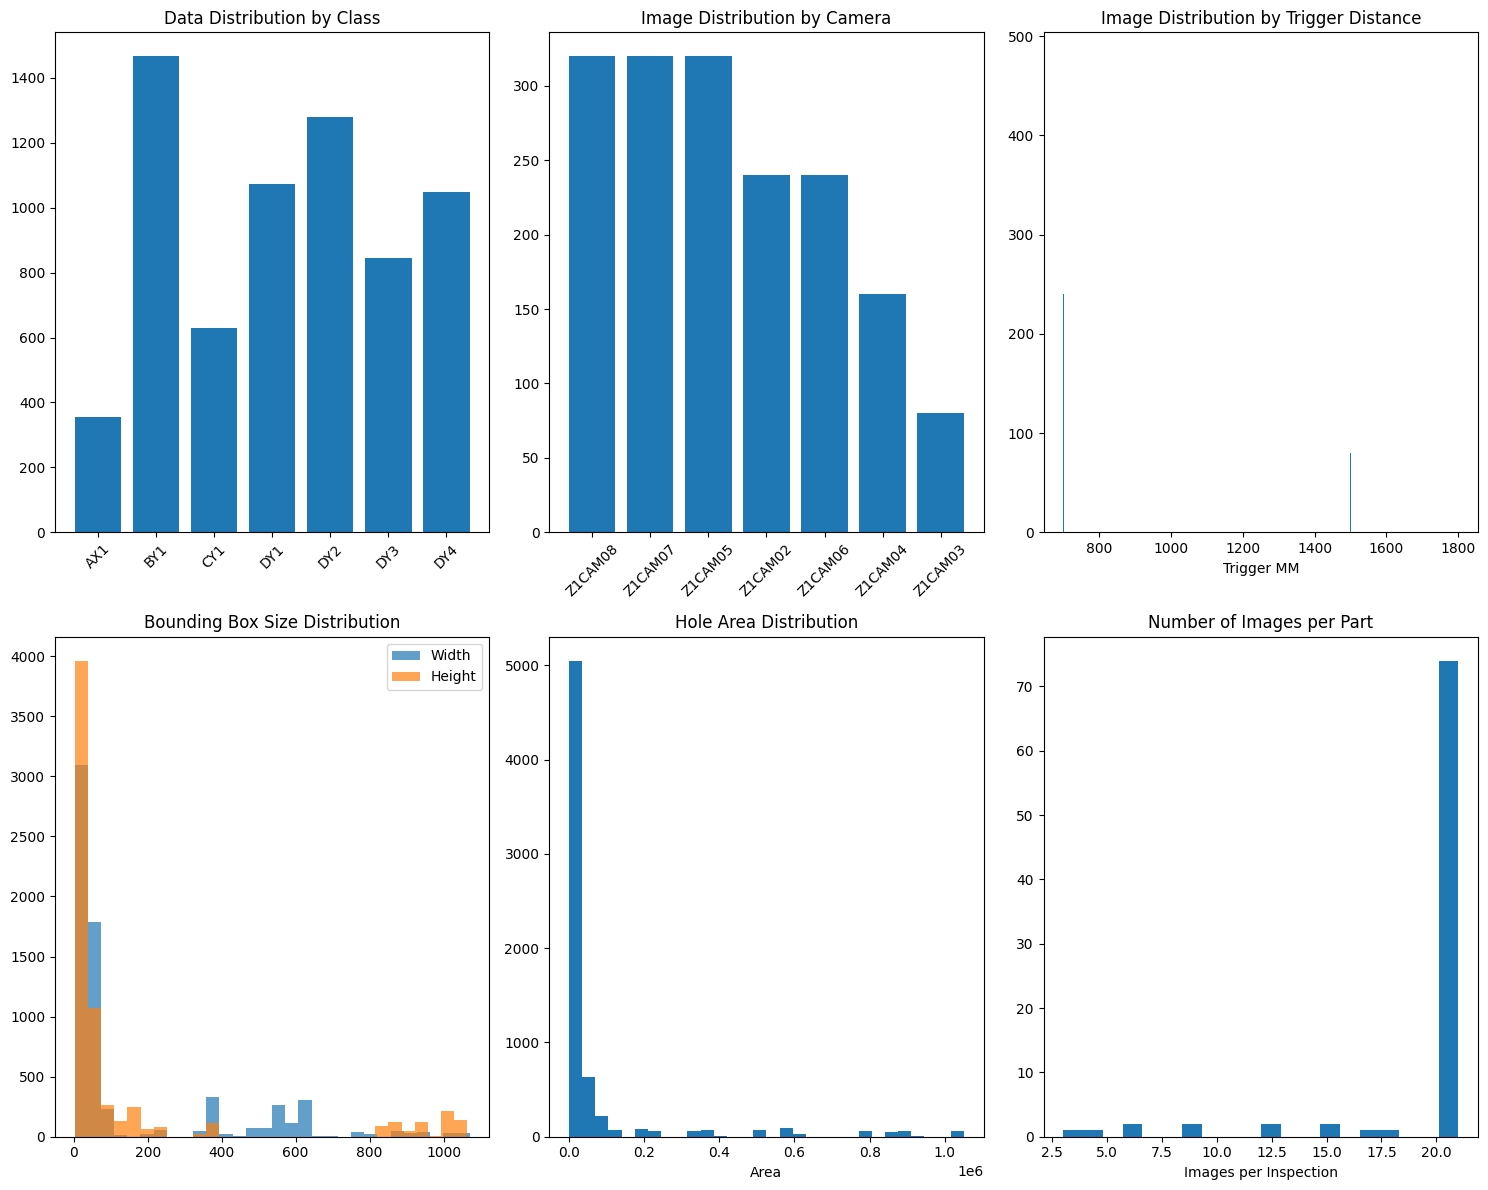

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

# 1. 클래스별 분포
plt.subplot(2, 3, 1)
category_names = [categories_df[categories_df['id'] == cat_id]['name'].iloc[0]
                 for cat_id in category_counts.index]
plt.bar(category_names, category_counts.values)
plt.title('Data Distribution by Class')
plt.xticks(rotation=45)

# 2. 카메라별 분포
plt.subplot(2, 3, 2)
plt.bar(cam_distribution.index, cam_distribution.values)
plt.title('Image Distribution by Camera')
plt.xticks(rotation=45)

# 3. 거리별 분포
plt.subplot(2, 3, 3)
plt.bar(trigger_distribution.index, trigger_distribution.values)
plt.title('Image Distribution by Trigger Distance')
plt.xlabel('Trigger MM')

# 4. 바운딩 박스 크기 분포
plt.subplot(2, 3, 4)
plt.hist(annotations_df['bbox_width'], bins=30, alpha=0.7, label='Width')
plt.hist(annotations_df['bbox_height'], bins=30, alpha=0.7, label='Height')
plt.title('Bounding Box Size Distribution')
plt.legend()

# 5. 면적 분포
plt.subplot(2, 3, 5)
plt.hist(annotations_df['area'], bins=30)
plt.title('Hole Area Distribution')
plt.xlabel('Area')

# 6. inspection당 이미지 개수
plt.subplot(2, 3, 6)
plt.hist(images_per_inspection.values, bins=20)
plt.title('Number of Images per Part')
plt.xlabel('Images per Inspection')

plt.tight_layout()
plt.show()